In [1]:
import pandas as pd
import zipfile
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb


In [2]:
zip_path = "ALLFLOWMETER_HIKARI2021.zip"
with zipfile.ZipFile(zip_path, 'r') as zipped_file:
    csv_file_name = zipped_file.namelist()[0]
    with zipped_file.open(csv_file_name) as csv_file:
        df = pd.read_csv(csv_file)


In [3]:
encoder = LabelEncoder()

def LabelEncoding(df):
    object_features = df.select_dtypes(include=['object'])
    for col in object_features:
        df[col] = encoder.fit_transform(df[col])
    return df


In [4]:
df = LabelEncoding(df)

In [5]:
df = df.drop('Label', axis=1)
X, y = df.drop('traffic_category', axis=1), df['traffic_category']

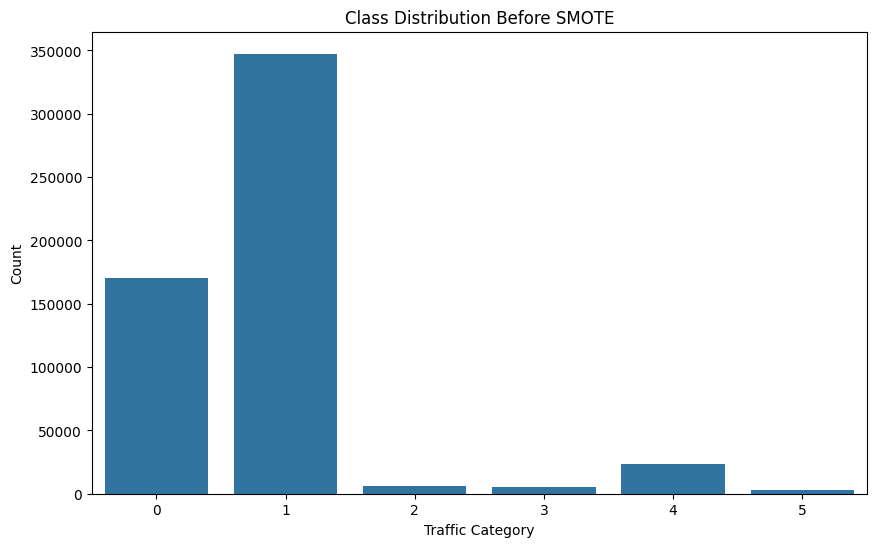

In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(x='traffic_category', data=df)
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Traffic Category')
plt.ylabel('Count')
plt.show()

In [8]:
smote = SMOTE(random_state=42)

X_resampled, y_resampled = smote.fit_resample(X,y)

df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['traffic_category'])], axis=1)

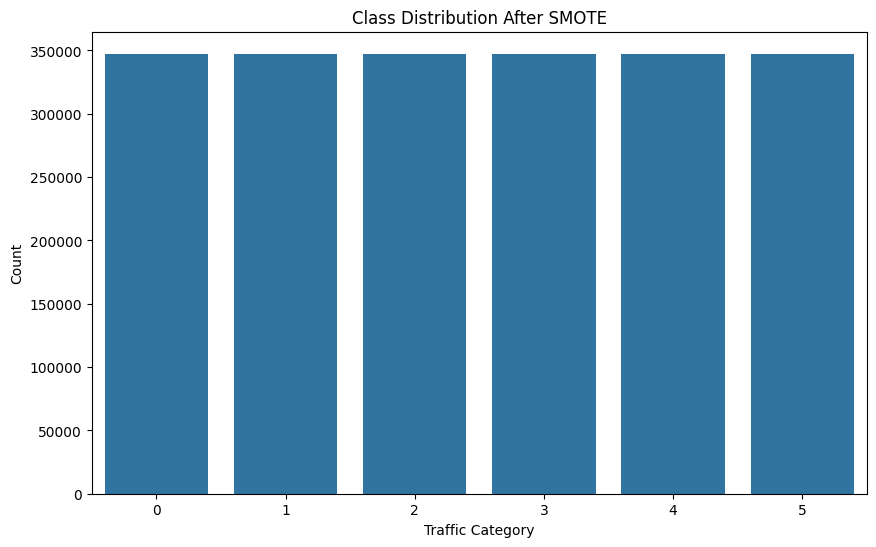

In [9]:
plt.figure(figsize=(10, 6))
sns.countplot(x='traffic_category', data=df_resampled)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Traffic Category')
plt.ylabel('Count')
plt.show()

In [10]:
X_resampled.columns = X_resampled.columns.str.replace('[^A-Za-z0-9_]', '_', regex=True)

print(X_resampled.columns)

Index(['Unnamed__0_1', 'Unnamed__0', 'uid', 'originh', 'originp', 'responh',
       'responp', 'flow_duration', 'fwd_pkts_tot', 'bwd_pkts_tot',
       'fwd_data_pkts_tot', 'bwd_data_pkts_tot', 'fwd_pkts_per_sec',
       'bwd_pkts_per_sec', 'flow_pkts_per_sec', 'down_up_ratio',
       'fwd_header_size_tot', 'fwd_header_size_min', 'fwd_header_size_max',
       'bwd_header_size_tot', 'bwd_header_size_min', 'bwd_header_size_max',
       'flow_FIN_flag_count', 'flow_SYN_flag_count', 'flow_RST_flag_count',
       'fwd_PSH_flag_count', 'bwd_PSH_flag_count', 'flow_ACK_flag_count',
       'fwd_URG_flag_count', 'bwd_URG_flag_count', 'flow_CWR_flag_count',
       'flow_ECE_flag_count', 'fwd_pkts_payload_min', 'fwd_pkts_payload_max',
       'fwd_pkts_payload_tot', 'fwd_pkts_payload_avg', 'fwd_pkts_payload_std',
       'bwd_pkts_payload_min', 'bwd_pkts_payload_max', 'bwd_pkts_payload_tot',
       'bwd_pkts_payload_avg', 'bwd_pkts_payload_std', 'flow_pkts_payload_min',
       'flow_pkts_payload_max'

In [11]:
df_resampled = df_resampled.loc[:, ~df_resampled.columns.str.contains('^Unnamed')]
df_resampled.columns = df_resampled.columns.str.replace('[^A-Za-z0-9_]', '_', regex=True)

print(df_resampled.columns)

Index(['uid', 'originh', 'originp', 'responh', 'responp', 'flow_duration',
       'fwd_pkts_tot', 'bwd_pkts_tot', 'fwd_data_pkts_tot',
       'bwd_data_pkts_tot', 'fwd_pkts_per_sec', 'bwd_pkts_per_sec',
       'flow_pkts_per_sec', 'down_up_ratio', 'fwd_header_size_tot',
       'fwd_header_size_min', 'fwd_header_size_max', 'bwd_header_size_tot',
       'bwd_header_size_min', 'bwd_header_size_max', 'flow_FIN_flag_count',
       'flow_SYN_flag_count', 'flow_RST_flag_count', 'fwd_PSH_flag_count',
       'bwd_PSH_flag_count', 'flow_ACK_flag_count', 'fwd_URG_flag_count',
       'bwd_URG_flag_count', 'flow_CWR_flag_count', 'flow_ECE_flag_count',
       'fwd_pkts_payload_min', 'fwd_pkts_payload_max', 'fwd_pkts_payload_tot',
       'fwd_pkts_payload_avg', 'fwd_pkts_payload_std', 'bwd_pkts_payload_min',
       'bwd_pkts_payload_max', 'bwd_pkts_payload_tot', 'bwd_pkts_payload_avg',
       'bwd_pkts_payload_std', 'flow_pkts_payload_min',
       'flow_pkts_payload_max', 'flow_pkts_payload_tot',
   

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.6, random_state=42)  # 40% train, 60% test

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_final = X_train_scaled
X_test_final = X_test_scaled

In [46]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np

selector = SelectKBest(f_classif, k=10) 
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='euclidean')

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_knn = cross_val_score(knn, X_train_selected, y_train, cv=kf, scoring='accuracy')

knn.fit(X_train_selected, y_train)

y_pred_knn = knn.predict(X_test_selected)

print("\nKNN Classification Report:")
print(classification_report(y_test, y_pred_knn))
print("KNN Accuracy: ", accuracy_score(y_test, y_pred_knn))
print(f"KNN Cross-Validation Scores: {cv_scores_knn}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_scores_knn)}")


KNN Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    208501
           1       1.00      1.00      1.00    208461
           2       1.00      1.00      1.00    208606
           3       1.00      1.00      1.00    208406
           4       1.00      1.00      1.00    208466
           5       1.00      1.00      1.00    208312

    accuracy                           1.00   1250752
   macro avg       1.00      1.00      1.00   1250752
weighted avg       1.00      1.00      1.00   1250752

KNN Accuracy:  0.9988119147520852
KNN Cross-Validation Scores: [0.99872277 0.99875875 0.99855487 0.99877674 0.99854287]
Mean Cross-Validation Accuracy: 0.9986711981901317
